# Reconnaissance de chiffre en language des signes avec pytorch

Dans cette exemple d'utilisation de deep learning, nous allons utiliser une base de donnée de 2061 images de mains faisant un chiffre en language des signes. Ces images sont en nuances de gris et dans une de plage de 0 à 1.
Nous disposons également des vérités terrains associés à chaque image sous forme d'un tableau de taille 10 avec un 1 à l'index de la classe correspondante.

Pour effectuer l'apprentissage nous allons utiliser pytorch.

## Chargement des images

In [1]:
#Import des modules pythons nécessaires
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch.utils.data as utils
from random import shuffle
import matplotlib.pyplot as plt
#Affichage de la graine d'aléatoire actuelle (afin de reproduire des résultats si nécessaire)
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#Chargement de cuda
device = torch.device("cuda:0")

Random Seed:  1903


Avant d'aller plus en profondeur avec des réseaux de neurone il faut tout d'abord charger les données.
Pour cela nous chargons directement les images via numpy et pour et les vérités terrains nous avons décider de ramener le tableau à 1 unique valeur représentant l'axe.

<PIL.Image.Image image mode=L size=32x32 at 0x7F91EB0E22B0>
Classes :  0.0


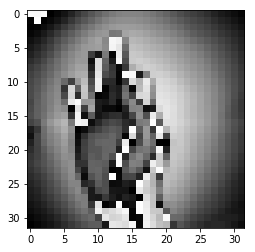

In [4]:
#Chargement des images
#L'image est d'abord redimmensionnée
#Puis noramlisé entre -0.5 et 0.5
Trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
images = [Trans(Image.fromarray(im)) for im in np.load("./datas/X.npy")]
#Chargement des classes
temp = np.load("./datas/Y.npy")
classes = np.zeros(len(images))
for i in range(len(classes)):
    classes[i] = temp[i].nonzero()[0][0]
plt.imshow(transforms.ToPILImage()(images[0]))
print(transforms.ToPILImage()(images[0]))
print("Classes : ",classes[0])

Pour avoir des datasets cohérents il faut aussi mélanger les données de bases

In [5]:
#Mélange du dataset
temp_s = []
for i in range(len(classes)):
    temp_s.append([images[i],classes[i] ])
shuffle(temp_s)
for i in range(len(classes)):
    [im,c] = temp_s[i]
    images[i] = im
    classes[i] = c

Maintenant que nous avons nore dataset il faut le partitionner pour avoir un ensemble pour l'entraînement
et un pour les tests (afin de vérifier que notre réseau n'apprend pas par coeur)

In [6]:
#Définition des partitions du dataset
#Nous choisissons de prendre un dataset d'entrainement représentant 80% des données
prc_train = int(0.80*len(images))
prc_test = prc_train + int(0.2*len(images))
#Chargement des partitions
def load():
    out = []
    prc = [prc_train,prc_test]
    for i in range(len(prc)):
        if i == 0:
            images_train = [(im) for im in images[:prc[i]]]
            classes_train = classes[:prc_train]
        #elif i == len(prc)-1:
        #    images_train = [(im) for im in images[prc[i]:]]
        #    classes_train = classes[prc[i]:]
        else:
            images_train = [(im) for im  in images[prc[i-1]:prc[i]]]
            classes_train = classes[prc_train:prc_test]
        tensor_x_train = torch.stack([torch.Tensor(i) for i in images_train])
        tensor_y_train = torch.from_numpy(classes_train).long()
        datas_train = utils.TensorDataset(tensor_x_train,tensor_y_train)
        dataloader_train = utils.DataLoader(datas_train,50, shuffle=True)
        out.append(dataloader_train)
    return out
[dataloader_train,dataloader_test] = load()

Ensuite il faut définir les fonctions d'entraînements et de test associé pour entraîner nos réseaux

In [7]:
def train(model, dataloader_train, optimizer, epoch, criterion):
    model.train()
    sum_loss = 0
    for i, (data,target) in enumerate(dataloader_train, 0):
        data, target = data.to(device), target.to(device)
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #print(output)
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(dataloader_train.dataset),
                100. * i / len(dataloader_train), loss.item()))
        return loss.item()
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data,target) in enumerate(test_loader, 0):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

## Réseau full connected

Maintenant nous pouvons passer à la définition de notre réseau, nous allons tout d'abord commencer avec un perceptron multicouche.

In [8]:
class Net_FC(nn.Module):
    def __init__(self):
        super(Net_FC, self).__init__()
        self.fc1 = nn.Linear(32*32,200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1,32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_FC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Il est maintenant temps de lancer notre premier apprentissage et voir les résultats

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.290856

Test set: Average loss: 2.7073, Accuracy: 36/412 (9%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 2.585151

Test set: Average loss: 2.3781, Accuracy: 53/412 (13%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.351195

Test set: Average loss: 2.2886, Accuracy: 51/412 (12%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.309406

Test set: Average loss: 2.2637, Accuracy: 77/412 (19%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.201338

Test set: Average loss: 2.2913, Accuracy: 50/412 (12%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.254018

Test set: Average loss: 2.3171, Accuracy: 46/412 (11%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.399055

Test set: Average loss: 2.2591, Accuracy: 59/412 (14%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 2.298419

Test set: Average loss: 2.2220, Accuracy: 80/412 (19%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 2.209714

Test set: Average loss: 2.2268, Accuracy: 63/412 (15%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 2.205971

Test set: Average loss: 2.2290, Accuracy: 56/41

Train Epoch: 86 [0/1649 (0%)]	Loss: 2.208799

Test set: Average loss: 2.1349, Accuracy: 75/412 (18%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 1.964147

Test set: Average loss: 2.1382, Accuracy: 78/412 (19%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 2.209339

Test set: Average loss: 2.1411, Accuracy: 78/412 (19%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 2.209634

Test set: Average loss: 2.1346, Accuracy: 77/412 (19%)

Train Epoch: 90 [0/1649 (0%)]	Loss: 2.214334

Test set: Average loss: 2.1325, Accuracy: 75/412 (18%)

Train Epoch: 91 [0/1649 (0%)]	Loss: 2.094725

Test set: Average loss: 2.1381, Accuracy: 74/412 (18%)

Train Epoch: 92 [0/1649 (0%)]	Loss: 2.146250

Test set: Average loss: 2.1536, Accuracy: 70/412 (17%)

Train Epoch: 93 [0/1649 (0%)]	Loss: 2.013345

Test set: Average loss: 2.1772, Accuracy: 65/412 (16%)

Train Epoch: 94 [0/1649 (0%)]	Loss: 1.984871

Test set: Average loss: 2.1459, Accuracy: 72/412 (17%)

Train Epoch: 95 [0/1649 (0%)]	Loss: 2.139299

Test set: Average loss: 2.1322, Accu


Test set: Average loss: 2.1395, Accuracy: 78/412 (19%)

Train Epoch: 180 [0/1649 (0%)]	Loss: 2.127849

Test set: Average loss: 2.1420, Accuracy: 80/412 (19%)

Train Epoch: 181 [0/1649 (0%)]	Loss: 1.949809

Test set: Average loss: 2.1495, Accuracy: 81/412 (20%)

Train Epoch: 182 [0/1649 (0%)]	Loss: 2.142915

Test set: Average loss: 2.1533, Accuracy: 80/412 (19%)

Train Epoch: 183 [0/1649 (0%)]	Loss: 2.212173

Test set: Average loss: 2.1564, Accuracy: 80/412 (19%)

Train Epoch: 184 [0/1649 (0%)]	Loss: 2.166791

Test set: Average loss: 2.1601, Accuracy: 80/412 (19%)

Train Epoch: 185 [0/1649 (0%)]	Loss: 2.261411

Test set: Average loss: 2.1621, Accuracy: 79/412 (19%)

Train Epoch: 186 [0/1649 (0%)]	Loss: 2.164511

Test set: Average loss: 2.1637, Accuracy: 78/412 (19%)

Train Epoch: 187 [0/1649 (0%)]	Loss: 2.191445

Test set: Average loss: 2.1580, Accuracy: 80/412 (19%)

Train Epoch: 188 [0/1649 (0%)]	Loss: 1.991612

Test set: Average loss: 2.1507, Accuracy: 80/412 (19%)

Train Epoch: 189

Train Epoch: 277 [0/1649 (0%)]	Loss: 2.093644

Test set: Average loss: 2.1655, Accuracy: 74/412 (18%)

Train Epoch: 278 [0/1649 (0%)]	Loss: 2.145223

Test set: Average loss: 2.1416, Accuracy: 76/412 (18%)

Train Epoch: 279 [0/1649 (0%)]	Loss: 2.029362

Test set: Average loss: 2.1298, Accuracy: 76/412 (18%)

Train Epoch: 280 [0/1649 (0%)]	Loss: 2.135718

Test set: Average loss: 2.1222, Accuracy: 79/412 (19%)

Train Epoch: 281 [0/1649 (0%)]	Loss: 2.046844

Test set: Average loss: 2.1224, Accuracy: 80/412 (19%)

Train Epoch: 282 [0/1649 (0%)]	Loss: 2.047261

Test set: Average loss: 2.1268, Accuracy: 81/412 (20%)

Train Epoch: 283 [0/1649 (0%)]	Loss: 2.095143

Test set: Average loss: 2.1314, Accuracy: 81/412 (20%)

Train Epoch: 284 [0/1649 (0%)]	Loss: 2.165808

Test set: Average loss: 2.1363, Accuracy: 81/412 (20%)

Train Epoch: 285 [0/1649 (0%)]	Loss: 2.203909

Test set: Average loss: 2.1326, Accuracy: 81/412 (20%)

Train Epoch: 286 [0/1649 (0%)]	Loss: 2.126725

Test set: Average loss: 2.


Test set: Average loss: 2.1189, Accuracy: 81/412 (20%)

Train Epoch: 374 [0/1649 (0%)]	Loss: 2.005991

Test set: Average loss: 2.1171, Accuracy: 81/412 (20%)

Train Epoch: 375 [0/1649 (0%)]	Loss: 2.103997

Test set: Average loss: 2.1132, Accuracy: 80/412 (19%)

Train Epoch: 376 [0/1649 (0%)]	Loss: 2.123153

Test set: Average loss: 2.1144, Accuracy: 80/412 (19%)

Train Epoch: 377 [0/1649 (0%)]	Loss: 2.029124

Test set: Average loss: 2.1205, Accuracy: 76/412 (18%)

Train Epoch: 378 [0/1649 (0%)]	Loss: 2.218660

Test set: Average loss: 2.1290, Accuracy: 76/412 (18%)

Train Epoch: 379 [0/1649 (0%)]	Loss: 2.265005

Test set: Average loss: 2.1198, Accuracy: 76/412 (18%)

Train Epoch: 380 [0/1649 (0%)]	Loss: 2.079014

Test set: Average loss: 2.1148, Accuracy: 79/412 (19%)

Train Epoch: 381 [0/1649 (0%)]	Loss: 2.210760

Test set: Average loss: 2.1135, Accuracy: 80/412 (19%)

Train Epoch: 382 [0/1649 (0%)]	Loss: 2.077666

Test set: Average loss: 2.1155, Accuracy: 81/412 (20%)

Train Epoch: 383

Train Epoch: 474 [0/1649 (0%)]	Loss: 2.030087

Test set: Average loss: 2.1295, Accuracy: 77/412 (19%)

Train Epoch: 475 [0/1649 (0%)]	Loss: 2.180190

Test set: Average loss: 2.1293, Accuracy: 77/412 (19%)

Train Epoch: 476 [0/1649 (0%)]	Loss: 2.171280

Test set: Average loss: 2.1278, Accuracy: 78/412 (19%)

Train Epoch: 477 [0/1649 (0%)]	Loss: 2.078100

Test set: Average loss: 2.1268, Accuracy: 78/412 (19%)

Train Epoch: 478 [0/1649 (0%)]	Loss: 2.120878

Test set: Average loss: 2.1259, Accuracy: 78/412 (19%)

Train Epoch: 479 [0/1649 (0%)]	Loss: 2.037905

Test set: Average loss: 2.1249, Accuracy: 79/412 (19%)

Train Epoch: 480 [0/1649 (0%)]	Loss: 2.210580

Test set: Average loss: 2.1256, Accuracy: 80/412 (19%)

Train Epoch: 481 [0/1649 (0%)]	Loss: 2.123280

Test set: Average loss: 2.1272, Accuracy: 80/412 (19%)

Train Epoch: 482 [0/1649 (0%)]	Loss: 2.050658

Test set: Average loss: 2.1273, Accuracy: 80/412 (19%)

Train Epoch: 483 [0/1649 (0%)]	Loss: 2.164457

Test set: Average loss: 2.

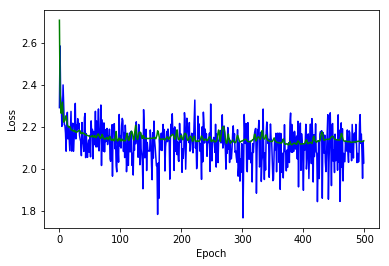

In [9]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Les résultats sont très peu concluant, on peut maintenant esasyer avec un réseau à convolution que l'on termine avec 2 couches full connected.

## Réseau à convolution

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 5, 1)
        self.fc1 = nn.Linear(5*5*128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x= self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*128)#Modification de la forme des donneés pour les faire rentrer dans les couches full connected
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #Utilisation de dropout pour ajouter de l'aléatoire à l'entraienement
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.302971

Test set: Average loss: 5.0488, Accuracy: 56/412 (14%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 5.151642

Test set: Average loss: 2.5290, Accuracy: 45/412 (11%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.584954

Test set: Average loss: 2.3014, Accuracy: 43/412 (10%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.297661

Test set: Average loss: 2.2974, Accuracy: 43/412 (10%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.317924

Test set: Average loss: 2.2946, Accuracy: 56/412 (14%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.295610

Test set: Average loss: 2.2911, Accuracy: 50/412 (12%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.290485

Test set: Average loss: 2.2846, Accuracy: 39/412 (9%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 2.299479

Test set: Average loss: 2.2782, Accuracy: 39/412 (9%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 2.277762

Test set: Average loss: 2.2705, Accuracy: 68/412 (17%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 2.279187

Test set: Average loss: 2.2572, Accuracy: 85/412

Train Epoch: 80 [0/1649 (0%)]	Loss: 0.335649

Test set: Average loss: 0.4573, Accuracy: 348/412 (84%)

Train Epoch: 81 [0/1649 (0%)]	Loss: 0.225585

Test set: Average loss: 0.4873, Accuracy: 342/412 (83%)

Train Epoch: 82 [0/1649 (0%)]	Loss: 0.582461

Test set: Average loss: 0.5300, Accuracy: 342/412 (83%)

Train Epoch: 83 [0/1649 (0%)]	Loss: 0.376702

Test set: Average loss: 0.5120, Accuracy: 344/412 (83%)

Train Epoch: 84 [0/1649 (0%)]	Loss: 0.824355

Test set: Average loss: 0.4999, Accuracy: 347/412 (84%)

Train Epoch: 85 [0/1649 (0%)]	Loss: 0.539483

Test set: Average loss: 0.4803, Accuracy: 348/412 (84%)

Train Epoch: 86 [0/1649 (0%)]	Loss: 0.373666

Test set: Average loss: 0.5102, Accuracy: 341/412 (83%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 0.382459

Test set: Average loss: 0.5325, Accuracy: 338/412 (82%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 0.548779

Test set: Average loss: 0.5207, Accuracy: 341/412 (83%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 0.422551

Test set: Average loss: 0.5

Train Epoch: 160 [0/1649 (0%)]	Loss: 0.125561

Test set: Average loss: 0.2786, Accuracy: 374/412 (91%)

Train Epoch: 161 [0/1649 (0%)]	Loss: 0.087325

Test set: Average loss: 0.2879, Accuracy: 374/412 (91%)

Train Epoch: 162 [0/1649 (0%)]	Loss: 0.380334

Test set: Average loss: 0.2944, Accuracy: 374/412 (91%)

Train Epoch: 163 [0/1649 (0%)]	Loss: 0.178270

Test set: Average loss: 0.2953, Accuracy: 374/412 (91%)

Train Epoch: 164 [0/1649 (0%)]	Loss: 0.261934

Test set: Average loss: 0.2978, Accuracy: 375/412 (91%)

Train Epoch: 165 [0/1649 (0%)]	Loss: 0.089837

Test set: Average loss: 0.3008, Accuracy: 375/412 (91%)

Train Epoch: 166 [0/1649 (0%)]	Loss: 0.108098

Test set: Average loss: 0.3211, Accuracy: 367/412 (89%)

Train Epoch: 167 [0/1649 (0%)]	Loss: 0.244097

Test set: Average loss: 0.3152, Accuracy: 372/412 (90%)

Train Epoch: 168 [0/1649 (0%)]	Loss: 0.254445

Test set: Average loss: 0.2989, Accuracy: 371/412 (90%)

Train Epoch: 169 [0/1649 (0%)]	Loss: 0.273631

Test set: Average


Test set: Average loss: 0.3045, Accuracy: 367/412 (89%)

Train Epoch: 244 [0/1649 (0%)]	Loss: 0.075156

Test set: Average loss: 0.2826, Accuracy: 366/412 (89%)

Train Epoch: 245 [0/1649 (0%)]	Loss: 0.132574

Test set: Average loss: 0.2692, Accuracy: 370/412 (90%)

Train Epoch: 246 [0/1649 (0%)]	Loss: 0.081038

Test set: Average loss: 0.2626, Accuracy: 373/412 (91%)

Train Epoch: 247 [0/1649 (0%)]	Loss: 0.126541

Test set: Average loss: 0.2589, Accuracy: 374/412 (91%)

Train Epoch: 248 [0/1649 (0%)]	Loss: 0.086021

Test set: Average loss: 0.2609, Accuracy: 378/412 (92%)

Train Epoch: 249 [0/1649 (0%)]	Loss: 0.178066

Test set: Average loss: 0.2662, Accuracy: 378/412 (92%)

Train Epoch: 250 [0/1649 (0%)]	Loss: 0.078716

Test set: Average loss: 0.2780, Accuracy: 377/412 (92%)

Train Epoch: 251 [0/1649 (0%)]	Loss: 0.080267

Test set: Average loss: 0.2989, Accuracy: 375/412 (91%)

Train Epoch: 252 [0/1649 (0%)]	Loss: 0.080593

Test set: Average loss: 0.3116, Accuracy: 376/412 (91%)

Train 


Test set: Average loss: 0.2246, Accuracy: 377/412 (92%)

Train Epoch: 323 [0/1649 (0%)]	Loss: 0.070761

Test set: Average loss: 0.2049, Accuracy: 375/412 (91%)

Train Epoch: 324 [0/1649 (0%)]	Loss: 0.154988

Test set: Average loss: 0.2048, Accuracy: 379/412 (92%)

Train Epoch: 325 [0/1649 (0%)]	Loss: 0.022654

Test set: Average loss: 0.2128, Accuracy: 379/412 (92%)

Train Epoch: 326 [0/1649 (0%)]	Loss: 0.279982

Test set: Average loss: 0.2256, Accuracy: 376/412 (91%)

Train Epoch: 327 [0/1649 (0%)]	Loss: 0.112595

Test set: Average loss: 0.2307, Accuracy: 375/412 (91%)

Train Epoch: 328 [0/1649 (0%)]	Loss: 0.038956

Test set: Average loss: 0.2342, Accuracy: 375/412 (91%)

Train Epoch: 329 [0/1649 (0%)]	Loss: 0.042661

Test set: Average loss: 0.2366, Accuracy: 375/412 (91%)

Train Epoch: 330 [0/1649 (0%)]	Loss: 0.069711

Test set: Average loss: 0.2328, Accuracy: 377/412 (92%)

Train Epoch: 331 [0/1649 (0%)]	Loss: 0.066113

Test set: Average loss: 0.2330, Accuracy: 379/412 (92%)

Train 


Test set: Average loss: 0.2489, Accuracy: 376/412 (91%)

Train Epoch: 403 [0/1649 (0%)]	Loss: 0.072415

Test set: Average loss: 0.2460, Accuracy: 381/412 (92%)

Train Epoch: 404 [0/1649 (0%)]	Loss: 0.057969

Test set: Average loss: 0.2454, Accuracy: 383/412 (93%)

Train Epoch: 405 [0/1649 (0%)]	Loss: 0.135727

Test set: Average loss: 0.2521, Accuracy: 380/412 (92%)

Train Epoch: 406 [0/1649 (0%)]	Loss: 0.040497

Test set: Average loss: 0.2647, Accuracy: 379/412 (92%)

Train Epoch: 407 [0/1649 (0%)]	Loss: 0.029439

Test set: Average loss: 0.2808, Accuracy: 378/412 (92%)

Train Epoch: 408 [0/1649 (0%)]	Loss: 0.069212

Test set: Average loss: 0.2807, Accuracy: 377/412 (92%)

Train Epoch: 409 [0/1649 (0%)]	Loss: 0.055118

Test set: Average loss: 0.2726, Accuracy: 376/412 (91%)

Train Epoch: 410 [0/1649 (0%)]	Loss: 0.221478

Test set: Average loss: 0.2705, Accuracy: 379/412 (92%)

Train Epoch: 411 [0/1649 (0%)]	Loss: 0.109376

Test set: Average loss: 0.2772, Accuracy: 377/412 (92%)

Train 


Test set: Average loss: 0.2860, Accuracy: 379/412 (92%)

Train Epoch: 484 [0/1649 (0%)]	Loss: 0.004580

Test set: Average loss: 0.2820, Accuracy: 379/412 (92%)

Train Epoch: 485 [0/1649 (0%)]	Loss: 0.012084

Test set: Average loss: 0.2792, Accuracy: 379/412 (92%)

Train Epoch: 486 [0/1649 (0%)]	Loss: 0.018104

Test set: Average loss: 0.2745, Accuracy: 379/412 (92%)

Train Epoch: 487 [0/1649 (0%)]	Loss: 0.025429

Test set: Average loss: 0.2718, Accuracy: 383/412 (93%)

Train Epoch: 488 [0/1649 (0%)]	Loss: 0.024925

Test set: Average loss: 0.2709, Accuracy: 382/412 (93%)

Train Epoch: 489 [0/1649 (0%)]	Loss: 0.017974

Test set: Average loss: 0.2752, Accuracy: 384/412 (93%)

Train Epoch: 490 [0/1649 (0%)]	Loss: 0.005192

Test set: Average loss: 0.2820, Accuracy: 382/412 (93%)

Train Epoch: 491 [0/1649 (0%)]	Loss: 0.017328

Test set: Average loss: 0.2883, Accuracy: 381/412 (92%)

Train Epoch: 492 [0/1649 (0%)]	Loss: 0.174694

Test set: Average loss: 0.2717, Accuracy: 383/412 (93%)

Train 

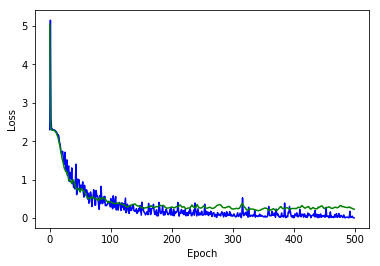

In [19]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Réseau residuel

Ici les résultats sont bien meilleurs pouvant atteindre les 95%.

Mais il est possible d'aller encore plus loin avec des architectures bien plus complexes.
Pour cette expérimentation nous allons essayer de construire une architecture de type ResNet (pour Residual Network).
Le principe est simple, après chaque convolution il y a une perte de l'information d'origine, ainsi pour pouvoir conserver ces informations lors du traitement il suffit de sauvegarder les données avant un ensemble de convolution, puis de venir les ajouter à la fin d'un ensemble de convolution. Ce type de d'opération s'appel un block résiduel, dans notre cas nous allons construire des blocks de 2 convolution 3*3, et pour venir injecter les données nous allons simplement faire la somme après la 2ème convolution.
Nous allons également utiliser des batchnorms entre chaque convolution pour améliorer les performances du réseau.
Ensuite notre réseau final sera constitué 4 bloc résiduel suivit de 2 couches full connected pour ramener l'informations à un ensemble traitable.

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    """Convolution 3*3 conservant la taille initiale de l'image en utilsant un padding de 1"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
padding=1, bias=False)

class ResBlock(nn.Module):
    """Définition d'un bloc résiduel"""
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        #Ajoute une couche supplémentaire pour redimenssioner le résidu si il ne possède pas la même
        #forme que la sortie des convolutions
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Net_RES_32(nn.Module):
    def __init__(self):
        super(Net_RES_32, self).__init__()
        self.b1 = ResBlock(1,32)
        self.b2 = ResBlock(32,32)
        self.b3 = ResBlock(32,64)
        self.b4 = ResBlock(64,128)
        self.fc1 = nn.Linear(64*4*4, 300)
        #self.fc1_b = nn.Linear(800, 200)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.b1(x)
        x = F.max_pool2d(x,2)

        x = self.b2(x)
        x = F.max_pool2d(x,2)

        x = self.b3(x)
        x = F.max_pool2d(x,2)
        #x = self.b4(x)
        #x = F.max_pool2d(x,2)

        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc1_b(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_RES_32().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


Ce réseau étant bien plus complexe que les précédent nous allons l'entraîner jusqu'à 1000 epoch.

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.264004

Test set: Average loss: 2.3031, Accuracy: 40/412 (10%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 3.325738

Test set: Average loss: 2.3018, Accuracy: 39/412 (9%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.929967

Test set: Average loss: 2.3026, Accuracy: 35/412 (8%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.500515

Test set: Average loss: 2.3033, Accuracy: 36/412 (9%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.684357

Test set: Average loss: 2.3023, Accuracy: 53/412 (13%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.295244

Test set: Average loss: 2.3018, Accuracy: 35/412 (8%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.071555

Test set: Average loss: 2.3012, Accuracy: 35/412 (8%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 2.249680

Test set: Average loss: 2.3000, Accuracy: 47/412 (11%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 2.074901

Test set: Average loss: 2.2946, Accuracy: 49/412 (12%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 1.834837

Test set: Average loss: 2.2891, Accuracy: 59/412 (1


Test set: Average loss: 0.2700, Accuracy: 381/412 (92%)

Train Epoch: 81 [0/1649 (0%)]	Loss: 0.186642

Test set: Average loss: 0.3177, Accuracy: 374/412 (91%)

Train Epoch: 82 [0/1649 (0%)]	Loss: 0.130830

Test set: Average loss: 0.3807, Accuracy: 364/412 (88%)

Train Epoch: 83 [0/1649 (0%)]	Loss: 0.213080

Test set: Average loss: 0.3928, Accuracy: 366/412 (89%)

Train Epoch: 84 [0/1649 (0%)]	Loss: 0.267508

Test set: Average loss: 0.3002, Accuracy: 381/412 (92%)

Train Epoch: 85 [0/1649 (0%)]	Loss: 0.113380

Test set: Average loss: 0.2423, Accuracy: 387/412 (94%)

Train Epoch: 86 [0/1649 (0%)]	Loss: 0.133329

Test set: Average loss: 0.2140, Accuracy: 389/412 (94%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 0.090644

Test set: Average loss: 0.2020, Accuracy: 389/412 (94%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 0.076541

Test set: Average loss: 0.1911, Accuracy: 392/412 (95%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 0.158763

Test set: Average loss: 0.1887, Accuracy: 391/412 (95%)

Train Epoch: 90

Train Epoch: 162 [0/1649 (0%)]	Loss: 0.080636

Test set: Average loss: 0.1264, Accuracy: 399/412 (97%)

Train Epoch: 163 [0/1649 (0%)]	Loss: 0.086244

Test set: Average loss: 0.1263, Accuracy: 399/412 (97%)

Train Epoch: 164 [0/1649 (0%)]	Loss: 0.028883

Test set: Average loss: 0.1323, Accuracy: 397/412 (96%)

Train Epoch: 165 [0/1649 (0%)]	Loss: 0.019792

Test set: Average loss: 0.1433, Accuracy: 396/412 (96%)

Train Epoch: 166 [0/1649 (0%)]	Loss: 0.026234

Test set: Average loss: 0.1579, Accuracy: 391/412 (95%)

Train Epoch: 167 [0/1649 (0%)]	Loss: 0.038524

Test set: Average loss: 0.1581, Accuracy: 393/412 (95%)

Train Epoch: 168 [0/1649 (0%)]	Loss: 0.026617

Test set: Average loss: 0.1571, Accuracy: 395/412 (96%)

Train Epoch: 169 [0/1649 (0%)]	Loss: 0.071897

Test set: Average loss: 0.1507, Accuracy: 393/412 (95%)

Train Epoch: 170 [0/1649 (0%)]	Loss: 0.056271

Test set: Average loss: 0.1385, Accuracy: 394/412 (96%)

Train Epoch: 171 [0/1649 (0%)]	Loss: 0.072773

Test set: Average

Train Epoch: 244 [0/1649 (0%)]	Loss: 0.059131

Test set: Average loss: 0.1241, Accuracy: 398/412 (97%)

Train Epoch: 245 [0/1649 (0%)]	Loss: 0.005396

Test set: Average loss: 0.1382, Accuracy: 398/412 (97%)

Train Epoch: 246 [0/1649 (0%)]	Loss: 0.016662

Test set: Average loss: 0.1877, Accuracy: 386/412 (94%)

Train Epoch: 247 [0/1649 (0%)]	Loss: 0.026369

Test set: Average loss: 0.2352, Accuracy: 382/412 (93%)

Train Epoch: 248 [0/1649 (0%)]	Loss: 0.077888

Test set: Average loss: 0.2299, Accuracy: 384/412 (93%)

Train Epoch: 249 [0/1649 (0%)]	Loss: 0.036052

Test set: Average loss: 0.2233, Accuracy: 385/412 (93%)

Train Epoch: 250 [0/1649 (0%)]	Loss: 0.123853

Test set: Average loss: 0.1444, Accuracy: 397/412 (96%)

Train Epoch: 251 [0/1649 (0%)]	Loss: 0.046367

Test set: Average loss: 0.1228, Accuracy: 398/412 (97%)

Train Epoch: 252 [0/1649 (0%)]	Loss: 0.020155

Test set: Average loss: 0.1401, Accuracy: 397/412 (96%)

Train Epoch: 253 [0/1649 (0%)]	Loss: 0.009866

Test set: Average


Test set: Average loss: 0.1557, Accuracy: 400/412 (97%)

Train Epoch: 326 [0/1649 (0%)]	Loss: 0.020027

Test set: Average loss: 0.1509, Accuracy: 400/412 (97%)

Train Epoch: 327 [0/1649 (0%)]	Loss: 0.009659

Test set: Average loss: 0.1452, Accuracy: 401/412 (97%)

Train Epoch: 328 [0/1649 (0%)]	Loss: 0.015562

Test set: Average loss: 0.1404, Accuracy: 402/412 (98%)

Train Epoch: 329 [0/1649 (0%)]	Loss: 0.010832

Test set: Average loss: 0.1398, Accuracy: 401/412 (97%)

Train Epoch: 330 [0/1649 (0%)]	Loss: 0.068467

Test set: Average loss: 0.1360, Accuracy: 402/412 (98%)

Train Epoch: 331 [0/1649 (0%)]	Loss: 0.015429

Test set: Average loss: 0.1378, Accuracy: 401/412 (97%)

Train Epoch: 332 [0/1649 (0%)]	Loss: 0.033399

Test set: Average loss: 0.1390, Accuracy: 401/412 (97%)

Train Epoch: 333 [0/1649 (0%)]	Loss: 0.001879

Test set: Average loss: 0.1433, Accuracy: 399/412 (97%)

Train Epoch: 334 [0/1649 (0%)]	Loss: 0.008690

Test set: Average loss: 0.1479, Accuracy: 397/412 (96%)

Train 


Test set: Average loss: 0.4046, Accuracy: 370/412 (90%)

Train Epoch: 407 [0/1649 (0%)]	Loss: 0.022273

Test set: Average loss: 0.3764, Accuracy: 372/412 (90%)

Train Epoch: 408 [0/1649 (0%)]	Loss: 0.026340

Test set: Average loss: 0.3099, Accuracy: 382/412 (93%)

Train Epoch: 409 [0/1649 (0%)]	Loss: 0.018966

Test set: Average loss: 0.2616, Accuracy: 386/412 (94%)

Train Epoch: 410 [0/1649 (0%)]	Loss: 0.068215

Test set: Average loss: 0.1685, Accuracy: 403/412 (98%)

Train Epoch: 411 [0/1649 (0%)]	Loss: 0.005255

Test set: Average loss: 0.1400, Accuracy: 404/412 (98%)

Train Epoch: 412 [0/1649 (0%)]	Loss: 0.020440

Test set: Average loss: 0.1285, Accuracy: 405/412 (98%)

Train Epoch: 413 [0/1649 (0%)]	Loss: 0.018349

Test set: Average loss: 0.1186, Accuracy: 404/412 (98%)

Train Epoch: 414 [0/1649 (0%)]	Loss: 0.003283

Test set: Average loss: 0.1143, Accuracy: 403/412 (98%)

Train Epoch: 415 [0/1649 (0%)]	Loss: 0.004394

Test set: Average loss: 0.1128, Accuracy: 402/412 (98%)

Train 

Train Epoch: 487 [0/1649 (0%)]	Loss: 0.049433

Test set: Average loss: 0.1667, Accuracy: 398/412 (97%)

Train Epoch: 488 [0/1649 (0%)]	Loss: 0.015559

Test set: Average loss: 0.1666, Accuracy: 399/412 (97%)

Train Epoch: 489 [0/1649 (0%)]	Loss: 0.048317

Test set: Average loss: 0.1662, Accuracy: 399/412 (97%)

Train Epoch: 490 [0/1649 (0%)]	Loss: 0.043003

Test set: Average loss: 0.1611, Accuracy: 400/412 (97%)

Train Epoch: 491 [0/1649 (0%)]	Loss: 0.056673

Test set: Average loss: 0.1408, Accuracy: 405/412 (98%)

Train Epoch: 492 [0/1649 (0%)]	Loss: 0.007425

Test set: Average loss: 0.1338, Accuracy: 405/412 (98%)

Train Epoch: 493 [0/1649 (0%)]	Loss: 0.055360

Test set: Average loss: 0.1275, Accuracy: 406/412 (99%)

Train Epoch: 494 [0/1649 (0%)]	Loss: 0.008251

Test set: Average loss: 0.1274, Accuracy: 405/412 (98%)

Train Epoch: 495 [0/1649 (0%)]	Loss: 0.010842

Test set: Average loss: 0.1294, Accuracy: 404/412 (98%)

Train Epoch: 496 [0/1649 (0%)]	Loss: 0.009286

Test set: Average

Train Epoch: 566 [0/1649 (0%)]	Loss: 0.068706

Test set: Average loss: 0.1540, Accuracy: 405/412 (98%)

Train Epoch: 567 [0/1649 (0%)]	Loss: 0.043357

Test set: Average loss: 0.1533, Accuracy: 404/412 (98%)

Train Epoch: 568 [0/1649 (0%)]	Loss: 0.004564

Test set: Average loss: 0.1548, Accuracy: 404/412 (98%)

Train Epoch: 569 [0/1649 (0%)]	Loss: 0.001927

Test set: Average loss: 0.1579, Accuracy: 403/412 (98%)

Train Epoch: 570 [0/1649 (0%)]	Loss: 0.018970

Test set: Average loss: 0.1583, Accuracy: 401/412 (97%)

Train Epoch: 571 [0/1649 (0%)]	Loss: 0.032149

Test set: Average loss: 0.1513, Accuracy: 399/412 (97%)

Train Epoch: 572 [0/1649 (0%)]	Loss: 0.007171

Test set: Average loss: 0.1468, Accuracy: 401/412 (97%)

Train Epoch: 573 [0/1649 (0%)]	Loss: 0.002677

Test set: Average loss: 0.1473, Accuracy: 402/412 (98%)

Train Epoch: 574 [0/1649 (0%)]	Loss: 0.016542

Test set: Average loss: 0.1456, Accuracy: 401/412 (97%)

Train Epoch: 575 [0/1649 (0%)]	Loss: 0.000700

Test set: Average


Test set: Average loss: 0.1622, Accuracy: 401/412 (97%)

Train Epoch: 649 [0/1649 (0%)]	Loss: 0.008133

Test set: Average loss: 0.1592, Accuracy: 401/412 (97%)

Train Epoch: 650 [0/1649 (0%)]	Loss: 0.002458

Test set: Average loss: 0.1559, Accuracy: 402/412 (98%)

Train Epoch: 651 [0/1649 (0%)]	Loss: 0.086619

Test set: Average loss: 0.1357, Accuracy: 404/412 (98%)

Train Epoch: 652 [0/1649 (0%)]	Loss: 0.018227

Test set: Average loss: 0.1297, Accuracy: 405/412 (98%)

Train Epoch: 653 [0/1649 (0%)]	Loss: 0.038866

Test set: Average loss: 0.1325, Accuracy: 403/412 (98%)

Train Epoch: 654 [0/1649 (0%)]	Loss: 0.004155

Test set: Average loss: 0.1429, Accuracy: 403/412 (98%)

Train Epoch: 655 [0/1649 (0%)]	Loss: 0.024638

Test set: Average loss: 0.1627, Accuracy: 401/412 (97%)

Train Epoch: 656 [0/1649 (0%)]	Loss: 0.007545

Test set: Average loss: 0.1800, Accuracy: 397/412 (96%)

Train Epoch: 657 [0/1649 (0%)]	Loss: 0.008237

Test set: Average loss: 0.1998, Accuracy: 395/412 (96%)

Train 

Train Epoch: 731 [0/1649 (0%)]	Loss: 0.129724

Test set: Average loss: 0.2757, Accuracy: 397/412 (96%)

Train Epoch: 732 [0/1649 (0%)]	Loss: 0.030239

Test set: Average loss: 0.2293, Accuracy: 398/412 (97%)

Train Epoch: 733 [0/1649 (0%)]	Loss: 0.000882

Test set: Average loss: 0.1985, Accuracy: 400/412 (97%)

Train Epoch: 734 [0/1649 (0%)]	Loss: 0.019791

Test set: Average loss: 0.1701, Accuracy: 400/412 (97%)

Train Epoch: 735 [0/1649 (0%)]	Loss: 0.016443

Test set: Average loss: 0.1459, Accuracy: 402/412 (98%)

Train Epoch: 736 [0/1649 (0%)]	Loss: 0.004268

Test set: Average loss: 0.1461, Accuracy: 400/412 (97%)

Train Epoch: 737 [0/1649 (0%)]	Loss: 0.089457

Test set: Average loss: 0.1224, Accuracy: 405/412 (98%)

Train Epoch: 738 [0/1649 (0%)]	Loss: 0.002428

Test set: Average loss: 0.1243, Accuracy: 405/412 (98%)

Train Epoch: 739 [0/1649 (0%)]	Loss: 0.001597

Test set: Average loss: 0.1310, Accuracy: 405/412 (98%)

Train Epoch: 740 [0/1649 (0%)]	Loss: 0.000408

Test set: Average

Train Epoch: 812 [0/1649 (0%)]	Loss: 0.001456

Test set: Average loss: 0.2080, Accuracy: 403/412 (98%)

Train Epoch: 813 [0/1649 (0%)]	Loss: 0.074041

Test set: Average loss: 0.2041, Accuracy: 403/412 (98%)

Train Epoch: 814 [0/1649 (0%)]	Loss: 0.018770

Test set: Average loss: 0.1964, Accuracy: 402/412 (98%)

Train Epoch: 815 [0/1649 (0%)]	Loss: 0.009719

Test set: Average loss: 0.1881, Accuracy: 403/412 (98%)

Train Epoch: 816 [0/1649 (0%)]	Loss: 0.010125

Test set: Average loss: 0.1842, Accuracy: 402/412 (98%)

Train Epoch: 817 [0/1649 (0%)]	Loss: 0.021878

Test set: Average loss: 0.1709, Accuracy: 403/412 (98%)

Train Epoch: 818 [0/1649 (0%)]	Loss: 0.011538

Test set: Average loss: 0.1591, Accuracy: 403/412 (98%)

Train Epoch: 819 [0/1649 (0%)]	Loss: 0.001234

Test set: Average loss: 0.1507, Accuracy: 404/412 (98%)

Train Epoch: 820 [0/1649 (0%)]	Loss: 0.005410

Test set: Average loss: 0.1456, Accuracy: 405/412 (98%)

Train Epoch: 821 [0/1649 (0%)]	Loss: 0.018644

Test set: Average

Train Epoch: 894 [0/1649 (0%)]	Loss: 0.052905

Test set: Average loss: 0.1467, Accuracy: 404/412 (98%)

Train Epoch: 895 [0/1649 (0%)]	Loss: 0.001301

Test set: Average loss: 0.1406, Accuracy: 404/412 (98%)

Train Epoch: 896 [0/1649 (0%)]	Loss: 0.001176

Test set: Average loss: 0.1374, Accuracy: 404/412 (98%)

Train Epoch: 897 [0/1649 (0%)]	Loss: 0.010726

Test set: Average loss: 0.1367, Accuracy: 403/412 (98%)

Train Epoch: 898 [0/1649 (0%)]	Loss: 0.001286

Test set: Average loss: 0.1373, Accuracy: 403/412 (98%)

Train Epoch: 899 [0/1649 (0%)]	Loss: 0.001690

Test set: Average loss: 0.1387, Accuracy: 402/412 (98%)

Train Epoch: 900 [0/1649 (0%)]	Loss: 0.001815

Test set: Average loss: 0.1415, Accuracy: 401/412 (97%)

Train Epoch: 901 [0/1649 (0%)]	Loss: 0.006277

Test set: Average loss: 0.1431, Accuracy: 401/412 (97%)

Train Epoch: 902 [0/1649 (0%)]	Loss: 0.039465

Test set: Average loss: 0.1399, Accuracy: 401/412 (97%)

Train Epoch: 903 [0/1649 (0%)]	Loss: 0.009239

Test set: Average

Train Epoch: 974 [0/1649 (0%)]	Loss: 0.004453

Test set: Average loss: 0.1163, Accuracy: 405/412 (98%)

Train Epoch: 975 [0/1649 (0%)]	Loss: 0.002882

Test set: Average loss: 0.1348, Accuracy: 403/412 (98%)

Train Epoch: 976 [0/1649 (0%)]	Loss: 0.029170

Test set: Average loss: 0.1788, Accuracy: 397/412 (96%)

Train Epoch: 977 [0/1649 (0%)]	Loss: 0.010380

Test set: Average loss: 0.2849, Accuracy: 384/412 (93%)

Train Epoch: 978 [0/1649 (0%)]	Loss: 0.028313

Test set: Average loss: 0.4178, Accuracy: 375/412 (91%)

Train Epoch: 979 [0/1649 (0%)]	Loss: 0.115167

Test set: Average loss: 0.4976, Accuracy: 367/412 (89%)

Train Epoch: 980 [0/1649 (0%)]	Loss: 0.085025

Test set: Average loss: 0.3648, Accuracy: 381/412 (92%)

Train Epoch: 981 [0/1649 (0%)]	Loss: 0.279135

Test set: Average loss: 0.1792, Accuracy: 401/412 (97%)

Train Epoch: 982 [0/1649 (0%)]	Loss: 0.001225

Test set: Average loss: 0.1619, Accuracy: 401/412 (97%)

Train Epoch: 983 [0/1649 (0%)]	Loss: 0.034711

Test set: Average

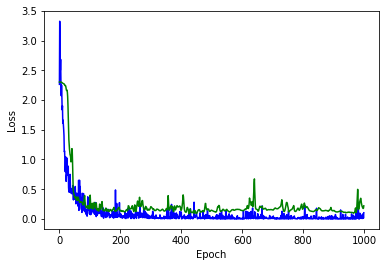

In [9]:
epoch_arr = range(1000)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

On peut voir qu'avec cette architecture les résultats sont impressionnant et peuvent atteindre les 99%.

## Utilisation du réseau

Maintenant que nous avons un réseau foncitonnel il est temps de s'en servir !


In [63]:
#Extraction et mapping du résultat issu du Tensor (par exemple plusieurs classes représentent un 3)
def map_result(tensor):
    map = {
        0 : 9,
        1 : 0,
        2 : 7,
        3 : 6,
        4 : 1,
        5 : 8,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 5,
    }
    
    '''
        0 : 3,
        1 : 0,
        2 : 3,
        3 : 3,
        4 : 1,
        5 : 3,
        6 : 4,
        7 : 3,
        8 : 2,
        9 : 5,
    '''
    return map[tensor.argmax(dim=1, keepdim=True)[0][0].item()]
    
    
#Chargement du dernier meilleur model
model.load_state_dict(torch.load("./best.pth"))
def test_on(model,path):
    model.eval()
    #Normalisation de l'image
    Trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
    im = Image.open(path).convert('L').resize((32,32))
    im.show()
    #Conversion en variable pytorch
    im = torch.autograd.Variable(Trans(im).unsqueeze_(0))
    #Evaluation
    with torch.no_grad():
            im = im.to(device)
            output = model(im)
            print("Output : ",output)
            print("Output : ",output.argmax(dim=1, keepdim=True))
            print(map_result(output))
            
#Test sur une image
#Il suffit de changer le chemin pour essayer sur une image.
test_on(model,"./datas/eval/hand_412.png")

Output :  tensor([[-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026]], device='cuda:0')
Output :  tensor([[0]], device='cuda:0')
9
